In [11]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from BOLLStrategy import BOLLStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [12]:
def run_backtest(config, trading_data, ohlc_data, window, a):
    window = int(window)
    config['title'] = "BOLLStrategy" + "_" + str(window) + "_" + str(a)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")

    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data=trading_data, ohlc_data=ohlc_data
    )
    strategy = BOLLStrategy(config, events_queue, data_handler,
                            window = window, a = a)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler=data_handler)

    results = backtest.start_trading()

    # dict_ans = {
    #     "window": [window],
    #     "a": [a],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return (results['cum_returns'][-1] - 1)

## Setting

In [13]:
config = {
    "csv_dir": "C:/backtest/Binance",
    "out_dir": "C:/backtest/results/BOLLStrategy",
    "title": "BOLLStrategy",
    "is_plot": False,
    "save_plot": False,
    "save_tradelog": False,
    "start_date": pd.Timestamp("2017-07-01T00:0:00", freq="60" + "T"),  # str(freq) + "T"
    "end_date": pd.Timestamp("2018-04-01T00:00:00", freq="60" + "T"),
    "equity": 1.0,
    "freq": 60,  # min
    "commission_ratio": 0.001,
    "suggested_quantity": None,  # None or a value
    "max_quantity": None,  # None or a value, Maximum purchase quantity
    "min_quantity": None,  # None or a value, Minimum purchase quantity
    "min_handheld_cash": None,  # None or a value, Minimum handheld funds
    "exchange": "Binance",
    "tickers": ['BTCUSDT']
}

In [14]:
# trading_data = {}
# for ticker in config['tickers']:
#     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
#     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

ohlc_data = {}
for ticker in config['tickers']:
    # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
    ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

trading_data = None

In [16]:
gp_params = {"alpha": 1e-5}

## Acquisition Function "Upper Confidence Bound"

* Prefer exploitation (kappa=1.0)

* Prefer exploration (kappa=10)


## Acquisition Function "Expected Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)

In [17]:
BO = BayesianOptimization(
    run_backtest,
    pbounds = {'window': (1, 240),
                'a': (0.1, 3)},
    is_int=[1, 0],
    invariant = {
        'config': config,
        'trading_data': trading_data,
        'ohlc_data': ohlc_data
    },
    random_state = 1
)
# BO.explore({
#         'window': np.arange(1, 240, 24),
#         'a': np.arange(0.1, 3, 0.3)
#     },
#     eager=True)
BO.maximize(init_points=20, n_iter=40, acq="ei", xi=0.01, **gp_params)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         a |    window | 
---------------------------------
BOLLStrategy_38_1.621189662761327
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8197338177
Max Drawdown: 47.1735237603
Max Drawdown Duration: 2736
Total Returns: 0.2956505663
---------------------------------
Trades: 28
Trade Winning: 50%
Average Trade: 1.76%
Average Win: 9.75%
Average Loss: -6.22%
Best Trade: 34.70%
Worst Trade: -17.93%
Worst Trade Date: 0 days 12:00:00
Avg Days in Trade: 2 days 21:49:17
---------------------------------
    1 | 00m04s |    0.29565 | 1.621190 | 38.000000 | 
---------------------------------
BOLLStrategy_236_1.386013391960714

---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3270410584
Max Drawdown: 49.0409717213
Max Drawdown Duration: 2510
Total Returns: 0.5886625142
---------------------------------
Trades: 5
Trade Winning: 60%
Average Trade: 14.94%
Average Win: 35.53%
Average Loss: -15.94%
Best Trade: 84.65%
Worst Trade: -16.41%
Worst Trade Date: 3 days 04:00:00
Avg Days in Trade: 12 days 01:00:00
---------------------------------
   11 | 00m09s |    0.58866 | 2.427997 | 130.000000 | 
---------------------------------
BOLLStrategy_205_0.36912234505814
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio:

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0887754289
Max Drawdown: 54.8645573675
Max Drawdown Duration: 2736
Total Returns: 0.4878320537
---------------------------------
Trades: 39
Trade Winning: 31%
Average Trade: 1.65%
Average Win: 12.74%
Average Loss: -3.27%
Best Trade: 36.97%
Worst Trade: -9.40%
Worst Trade Date: 1 days 12:00:00
Avg Days in Trade: 2 days 04:32:18
---------------------------------
   21 | 00m15s |    0.48783 | 0.115338 | 134.000000 | 
---------------------------------
BOLLStrategy_133_1.9736039449309297
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2112254252
Max Drawdown: 50.3337760057
Max Drawdown Duration: 2510
Total Returns: 0.54

---------------------------------
BOLLStrategy_81_0.7672603540341342
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2513480698
Max Drawdown: 40.1167888788
Max Drawdown Duration: 2736
Total Returns: 0.6317382855
---------------------------------
Trades: 24
Trade Winning: 38%
Average Trade: 2.83%
Average Win: 15.55%
Average Loss: -4.80%
Best Trade: 24.98%
Worst Trade: -9.73%
Worst Trade Date: 0 days 09:00:00
Avg Days in Trade: 3 days 08:45:00
---------------------------------
   32 | 00m14s |    0.63174 | 0.767260 | 81.000000 | 
---------------------------------
BOLLStrategy_147_0.10072571045023726
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7071866653
Max Drawdown: 51.0681037121
Max Drawdown Duration: 2510
Total Returns: 0.9869886468
---------------------------------
Trades: 9
Trade Winning: 44%
Average Trade: 13.49%
Average Win: 40.72%
Average Loss: -8.30%
Best Trade: 127.53%
Worst Trade: -18.68%
Worst Trade Date: 3 days 12:00:00
Avg Days in Trade: 9 days 02:33:20
---------------------------------
   42 | 00m19s |    0.98699 | 1.054522 | 154.000000 | 
---------------------------------
BOLLStrategy_155_3.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.8510049062
Max Drawdown: 27.7938177643
Max Drawdown Duration: 2510
Total Returns: 0.9475667544
----

---------------------------------
BOLLStrategy_45_2.8535986440352388
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7373663057
Max Drawdown: 39.5976754397
Max Drawdown Duration: 2736
Total Returns: 0.9503538035
---------------------------------
Trades: 8
Trade Winning: 62%
Average Trade: 10.51%
Average Win: 20.58%
Average Loss: -6.29%
Best Trade: 50.85%
Worst Trade: -14.99%
Worst Trade Date: 6 days 05:00:00
Avg Days in Trade: 8 days 14:52:30
---------------------------------
   53 | 00m12s |    0.95035 | 2.853599 | 45.000000 | 
---------------------------------
BOLLStrategy_197_0.1
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---

In [18]:
print(BO.res['max'])

{'max_val': 1.4276806010994907, 'max_params': {'window': 43.0, 'a': 3.0}}


In [19]:
BO.maximize(init_points=0, n_iter=40, acq="ei", xi=0.0001, **gp_params)

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         a |    window | 
---------------------------------
BOLLStrategy_134_1.1292201723207391
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7311327270
Max Drawdown: 52.3990250398
Max Drawdown Duration: 2510
Total Returns: 1.0160011976
---------------------------------
Trades: 11
Trade Winning: 45%
Average Trade: 12.07%
Average Win: 36.37%
Average Loss: -8.18%
Best Trade: 140.39%
Worst Trade: -19.29%
Worst Trade Date: 1 days 19:00:00
Avg Days in Trade: 7 days 11:21:49
---------------------------------
   61 | 00m19s |    1.01600 | 1.129220 | 134.000000 | 
---------------------------------
BOLLStrategy_158_2.99

---------------------------------
BOLLStrategy_218_0.7526987628624013
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7868280008
Max Drawdown: 41.8840371004
Max Drawdown Duration: 2510
Total Returns: 1.0495763911
---------------------------------
Trades: 8
Trade Winning: 38%
Average Trade: 15.26%
Average Win: 51.52%
Average Loss: -6.50%
Best Trade: 127.53%
Worst Trade: -10.28%
Worst Trade Date: 2 days 09:00:00
Avg Days in Trade: 10 days 03:00:00
---------------------------------
   71 | 00m22s |    1.04958 | 0.752699 | 218.000000 | 
---------------------------------
BOLLStrategy_219_2.6212186607512438
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8326530671
Max Drawdown: 49.7284649499
Max Drawdown Duration: 2510
Total Returns: 0.2953702198
---------------------------------
Trades: 3
Trade Winning: 67%
Average Trade: 12.40%
Average Win: 28.36%
Average Loss: -19.51%
Best Trade: 45.28%
Worst Trade: -19.51%
Worst Trade Date: 2 days 18:00:00
Avg Days in Trade: 22 days 03:20:00
---------------------------------
   81 | 00m17s |    0.29537 | 2.995223 | 108.000000 | 
---------------------------------
BOLLStrategy_106_0.11601539818705336
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8359500019
Max Drawdown: 52.8014379780
Max Drawdown Duration: 2736
Total Returns: 

---------------------------------
BOLLStrategy_153_1.9676809432114115
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5037817081
Max Drawdown: 43.2575702543
Max Drawdown Duration: 2510
Total Returns: 0.7260325667
---------------------------------
Trades: 7
Trade Winning: 43%
Average Trade: 13.43%
Average Win: 42.97%
Average Loss: -8.72%
Best Trade: 108.62%
Worst Trade: -12.13%
Worst Trade Date: 7 days 02:00:00
Avg Days in Trade: 11 days 03:17:09
---------------------------------
   92 | 00m14s |    0.72603 | 1.967681 | 153.000000 | 
---------------------------------
BOLLStrategy_156_2.0222107310598636
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018

In [72]:
print(BO.res['max'])

{'max_val': 1.4276806010994907, 'max_params': {'window': 43.0, 'a': 3.0}}


In [21]:
Target = pd.DataFrame({'Parameters': BO.X.tolist(), 'Target': BO.Y})
# Target.to_csv(config['out_dir'] + "/target_ei.csv")
Target.sort_values(by = "Target")

,Parameters,Target
46,"[9.0, 0.1]",-0.651757
54,"[65.0, 1.9139325404619403]",-0.072866
13,"[238.0, 2.608558730739052]",-0.072616
68,"[207.0, 2.9638665749321933]",-0.024764
17,"[21.0, 0.27180528377453406]",0.022117
3,"[73.0, 1.6498003359463493]",0.040335
71,"[219.0, 2.6212186607512438]",0.083422
12,"[72.0, 1.602642391931478]",0.103277
59,"[199.0, 2.8778796374364557]",0.168847
36,"[196.0, 2.8071512748840104]",0.258791


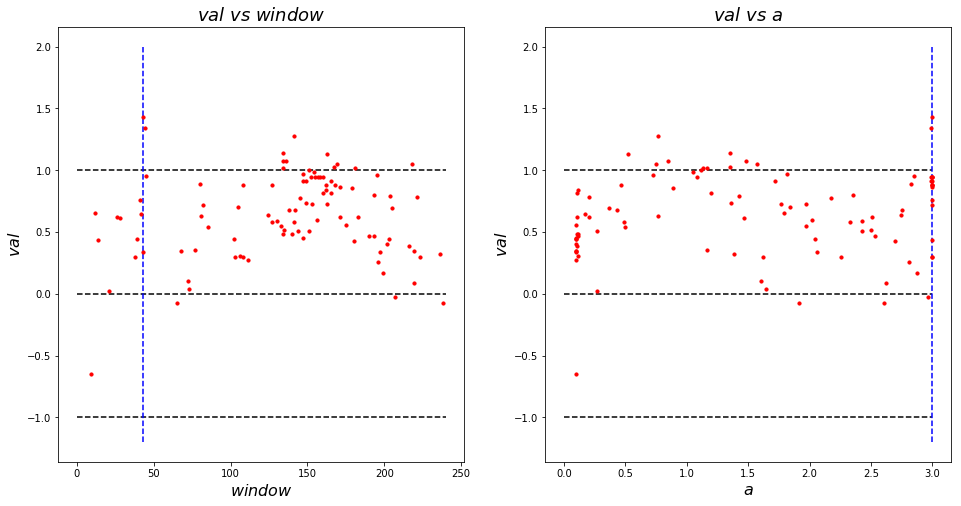

In [83]:
f, ax = plt.subplots(1,2, figsize = (16, 8))
ax[0].scatter(BO.X[:,0].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[0].set_xlabel('$window$', fontsize=16)
ax[0].set_ylabel('$val$', fontsize=16)
ax[0].hlines(0, 0, 240, color='black',linestyle="--")
ax[0].hlines(-1, 0, 240, color='black',linestyle="--")
ax[0].hlines(1, 0, 240, color='black',linestyle="--")
ax[0].vlines(BO.res['max']['max_params']['window'], -1.2, 2, color='blue',linestyle="--")

ax[1].scatter(BO.X[:,1].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[1].set_title('$val$ $vs$ $a$ ', fontsize=18)
ax[1].set_xlabel('$a$', fontsize=16)
ax[1].set_ylabel('$val$', fontsize=16)
ax[1].hlines(0, 0, 3,color='black',linestyle="--")
ax[1].hlines(-1, 0, 3, color='black',linestyle="--")
ax[1].hlines(1, 0, 3,color='black',linestyle="--")
ax[1].vlines(BO.res['max']['max_params']['a'], -1.2, 2, color='blue',linestyle="--")

## Acquisition Function "Probability of Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)